In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [4]:

path = r'../data/oricnd/'
images_filepaths = sorted([os.path.join(path,f) for f in os.listdir(path)])
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] # 38second

In [5]:
len(correct_images_filepaths)

25000

In [6]:
random.seed(42)    
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000] #성능을 향상시키고 싶다면 훈련 데이터셋을 늘려서 테스트해보세요   
val_images_filepaths = correct_images_filepaths[20000:-10] #훈련과 함께 검증도 늘려줘야 합니다
test_images_filepaths = correct_images_filepaths[-10:]    
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4990 10


In [7]:
class DogvsCatDataset(Dataset):
    def __init__(self,file_list, transforms=None, phase='train'):
        self.file_list = file_list
        self.transforms = transforms
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transormed = self.transforms(img,self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transormed,label

In [8]:
train_dataset = DogvsCatDataset(train_images_filepaths,transforms=ImageTransform(size,mean,std),phase = 'train')
vallid_dataset = DogvsCatDataset(val_images_filepaths,transforms=ImageTransform(size,mean,std),phase = 'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1


In [9]:
train_iterator = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(vallid_dataset,batch_size=batch_size, shuffle=False)
dataloader_dict = {'train':train_iterator, 'val':valid_iterator}

batch_iterator = iter(train_iterator)
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 1])


In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample = False):
        super(BasicBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv,bn)
        else:
            downsample = None
        self.downsample = downsample
    
    def forward(self,x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
        x += i
        x = self.relu(x)
        return x


In [11]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels,out_channels, stride=1,downsample=False):
        super(Bottleneck,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels,out_channels * self.expansion,kernel_size=1,stride=1,bias=False)
        self.bn3 =  nn.BatchNorm2d(out_channels *self.expansion)

        self.relu = nn.ReLU(inplace=True)

        if downsample:
            conv = nn.Conv2d(in_channels,out_channels*self.expansion,kernel_size=1,stride=stride,bias=False)
            bn = nn.BatchNorm2d(out_channels *self.expansion)
            downsample = nn.Sequential(conv,bn)    
        else:
            downsample = None
        
        self.downsample = downsample
    def forward(self,x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x) 
        x = self.relu(x)      
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)
        
        x += i
        x = self.relu(x)
        return x

In [12]:
class ResNet(nn.Module):
    def __init__(self,config,output_dim, zero_init_residual=False):
        super().__init__()

        block,n_blocks,channels = config
        self.in_channels = channels[0]
        assert len(n_blocks) == len( channels) == 4

        self.conv1 = nn.Conv2d(3,self.in_channels,kernel_size=7,stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block,n_blocks[1],channels[1],stride=2)
        self.layer3 = self.get_resnet_layer(block,n_blocks[2],channels[2],stride=2)
        self.layer4 = self.get_resnet_layer(block,n_blocks[3],channels[3],stride=2)

        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels,output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight,0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight,0)


    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        layers = []
        if self.in_channels != block.expansion * channels:
           downsample = True
        else:
            downsample = False
            
        layers.append(block(self.in_channels, channels,stride, downsample)) # downsample을 layer의 첫번째 block에서 진행한다.
        for i in range(1,n_blocks):
            layers.append(block(block.expansion*channels, channels))
            
        self.in_channels = block.expansion*channels
        return nn.Sequential(*layers)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg(x)
        h = x.view(x.shape[0],-1)
        x = self.fc(h)
        return x,h #리턴이 튜플이다~!


In [13]:

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [14]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [15]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [16]:
OUTPUT_DIM=2
PATH = r'../data/model/ResNet-model.pt'
model = ResNet(resnet50_config,OUTPUT_DIM)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
from torchsummary import summary
model.to(device)
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [19]:
# torch.topk : Returns the k largest elements of the given input tensor along a given dimension.
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1) # dim=1을 기준으로 top k개(크기순)를 선택해서 정렬한다 return (Torch,indices:torch.Size([32, 2]))
        top_pred = top_pred.t() # torch.Size([2, 32])
        # y.view(1, -1) : torch.Size([1, 32])
        # y.view(1, -1).expand_as(top_pred) : torch.Size([2, 32]) -> 같은걸 복사한다 
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        # correct[:1].reshape(-1): torch.Size([32])
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True) 
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True) # 결국 전체 [False, True]의 합 -> tensor([32], device='cuda:0')
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [20]:
inputs, labels = next(batch_iterator)
inputs = inputs.to(device)
labels = labels.to(device)
y_pred, _ = model(inputs)


In [21]:
y_pred.size()

torch.Size([32, 2])

In [22]:
y_pred

tensor([[-4.7702e-02, -4.8408e-01],
        [-6.1896e-01, -6.3971e-01],
        [-8.1648e-03, -6.1628e-01],
        [-4.0164e-01, -3.0731e-01],
        [-1.9734e-01, -3.0694e-01],
        [-1.4443e-01, -5.2134e-01],
        [-5.2855e-01,  4.3303e-02],
        [-3.3773e-01, -4.7500e-01],
        [-2.4150e-02, -5.1094e-01],
        [-1.8006e-01, -4.8636e-01],
        [-5.4415e-01, -2.1594e-01],
        [-8.2947e-01, -2.6602e-01],
        [-4.0994e-02, -4.2022e-01],
        [-4.1903e-01, -1.7559e-01],
        [ 9.1576e-02, -6.2408e-01],
        [-4.7038e-01, -6.3305e-01],
        [-2.4129e-01, -4.2968e-01],
        [-3.0345e-02, -5.0279e-01],
        [-1.0126e+00, -2.1508e-02],
        [-1.1049e-01, -4.3431e-01],
        [-8.6806e-01,  2.8735e-02],
        [ 6.2828e-02, -5.4210e-01],
        [-9.2981e-04, -6.1766e-01],
        [-4.8642e-01, -5.6004e-01],
        [-9.7697e-02, -3.2120e-01],
        [-3.7833e-01, -3.0011e-01],
        [-7.8584e-01, -5.3293e-02],
        [-1.1966e+00, -4.781

In [23]:
pred = y_pred.topk(2,1)[1].t()

In [24]:
labels

tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')

In [25]:
labels.view(1, -1).expand_as(pred)[0]

tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1], device='cuda:0')

In [26]:
correct = pred.eq(labels.view(1, -1).expand_as(pred))

In [27]:
correct[:2].reshape(-1).sum(0,keepdim=True)

tensor([32], device='cuda:0')

In [28]:
def train(model,iterator,optimizer,criterion,device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()
    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred[0],y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0],y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /=len(iterator)
    epoch_acc_5 /=len(iterator)
    return epoch_loss,epoch_acc_1,epoch_acc_5


In [29]:
def evaluate(model,iterator,criterion,device):
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred[0],y)
        
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0],y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /=len(iterator)
    epoch_acc_5 /=len(iterator)
    return epoch_loss,epoch_acc_1,epoch_acc_5


In [30]:
def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time//60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    return elapsed_mins,elapsed_secs

In [31]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '../data/model/ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 20s
	Train Loss: 0.653 | Train Acc @1:  61.32% | Train Acc @5: 100.00%
	Valid Loss: 0.650 | Valid Acc @1:  61.88% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 2m 17s
	Train Loss: 0.652 | Train Acc @1:  61.82% | Train Acc @5: 100.00%
	Valid Loss: 0.648 | Valid Acc @1:  62.45% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 2m 16s
	Train Loss: 0.652 | Train Acc @1:  61.86% | Train Acc @5: 100.00%
	Valid Loss: 0.649 | Valid Acc @1:  62.35% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 2m 8s
	Train Loss: 0.650 | Train Acc @1:  61.77% | Train Acc @5: 100.00%
	Valid Loss: 0.646 | Valid Acc @1:  62.95% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 2m 9s
	Train Loss: 0.650 | Train Acc @1:  61.83% | Train Acc @5: 100.00%
	Valid Loss: 0.647 | Valid Acc @1:  62.64% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 2m 18s
	Train Loss: 0.649 | Train Acc @1:  62.09% | Train Acc @5: 100.00%
	Valid Loss: 0.644 | Valid Acc @1:  63.35% | Valid Acc @5: 100.00%
Epoch: 07 | 

In [32]:
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in test_images_filepaths:
        img = Image.open(test_path)
        _id =test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('../Result/ReNet.csv', index=False)
res.head(10)

,id,label
0,10734,0.628615
1,1770,0.650719
2,2030,0.523597
3,2863,0.301896
4,5330,0.563681
5,5970,0.491122
6,6355,0.598436
7,686,0.552731
8,9217,0.362388
9,9368,0.319295


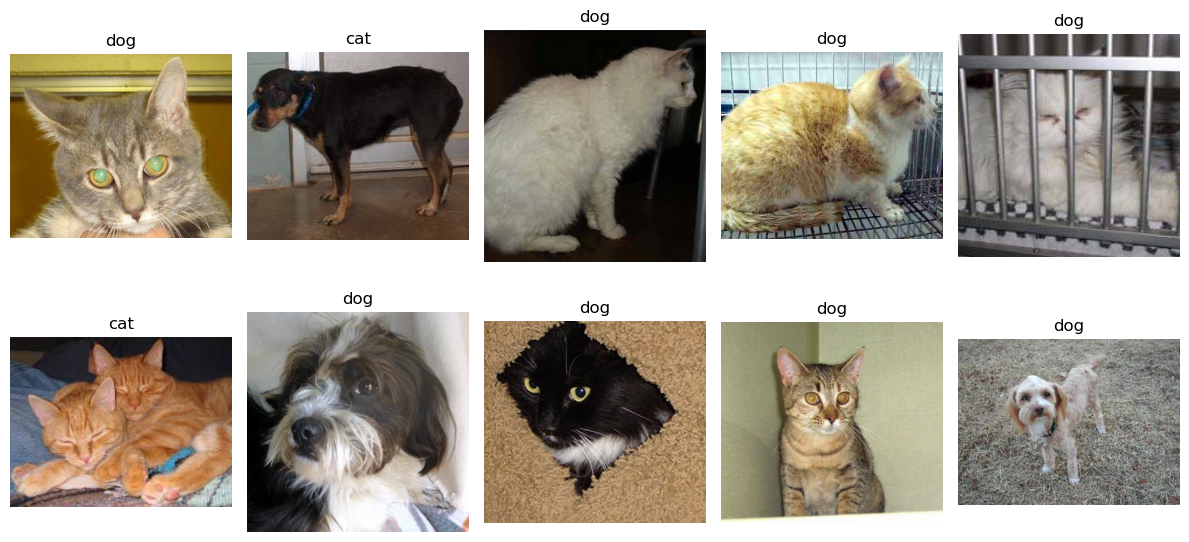

In [33]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths) 